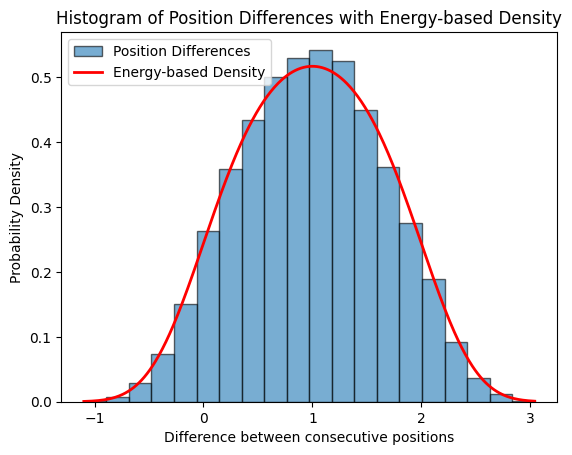

In [5]:
import numpy as np
import matplotlib.pyplot as plt



# Parameters
a = 0.0  # Coefficient for x^3 term
b = 1.0  # Coefficient for x^4 term
beta = 1.0  # Inverse temperature

# Step 1: Load the data and process it as before
all_positions = []
current_block = []

with open('condizioni_iniziali.dat', 'r') as f:  # Replace 'your_file.txt' with your actual filename
    for line in f:
        line = line.strip()
        if line and '-' not in line:  # Ignore separator lines
            position = float(line.split()[0])  # Extract the position (first column)
            current_block.append(position)
        elif current_block:  # If we hit a separator, save the block
            all_positions.append(current_block)
            current_block = []

    if current_block:  # Save the last block if no separator at end
        all_positions.append(current_block)

# Step 2: Calculate differences within each block
position_diffs = []
for block in all_positions:
    if len(block) > 1:
        diffs = np.diff(block)
        position_diffs.extend(diffs)

# Step 3: Plot histogram of position differences
plt.hist(position_diffs, bins=20, density=True, alpha=0.6, edgecolor='black', label='Position Differences')

# Step 4: Define the energy function and density based on Boltzmann distribution
def energy(x, a, b):
    return (x-1)**2/2 + a * (x-1)**3/3 + b * (x-1)**4/4

def density(x, a, b, beta):
    return np.exp(-beta * energy(x, a, b))

# Generate x values for plotting the density
x_vals = np.linspace(min(position_diffs), max(position_diffs), 500)
density_vals = density(x_vals, a, b, beta)
density_vals /= np.trapz(density_vals, x_vals)  # Normalize the density

# Step 5: Plot the density function
plt.plot(x_vals, density_vals, color='red', linewidth=2, label='Energy-based Density')

# Add labels and legend
plt.xlabel('Difference between consecutive positions')
plt.ylabel('Probability Density')
plt.title('Histogram of Position Differences with Energy-based Density')
plt.legend()
plt.show()